In [1]:
import sys
sys.path.insert(0, '..')

import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from intransparent import (
    combine_brands,
    ingest_reports_per_platform,
    REPORTS_PER_PLATFORM,
    show,
    wide_ncmec_reports,
)
import intransparent.meta as meta


_TDB_URL = (
'https://www.thedailybeast.com/facebook-a-hotbed-of-child-sexual-abuse-material-'
'with-203-million-reports-far-more-than-pornhub'
)


data = ingest_reports_per_platform(REPORTS_PER_PLATFORM)

show(f"<h1>Meta's Insufficient and Buggy Transparency</h1>")
show(f'<h2>Meta is a “<a href="{_TDB_URL}">Hotbed of CSAM</a>”</h2>')
show(
    """
    Meta is responsible for the vast majority of CyberTipline reports and also
    pieces. Yet, its transparency disclosures aren't very transparent.
    <ul>
    <li>Meta does not disclose the number of CSAM reports made to NCMEC, only
    pieces.</li>
    <li>At first, Meta only disclosed pieces for Facebook</li>
    <li>Starting with Q2 2019, Meta also disclosed piece counts for Instagram</li>
    <li>Starting with Q2 2021, Meta changed the definition of the corresponding metric</li>
    <li>Meta is the only social media firm to round its counts</li>
    <li>Meta makes no transparency disclosures for WhatsApp. Yet, it does file
    CSAM reports for the app. This became apparent when NCMEC started
    distinguishing between Facebook, Instagram, and WhatsApp for its 2021 transparency
    disclosures.</li>
    </ul>
    Furthermore, see below.
    """
)

ncmec = wide_ncmec_reports(data, drop_brands=False)
meta_reports = meta.csam_reports(ncmec)
show(
    meta_reports,
    caption="Meta's Share of CSAM Reports",
    highlight_columns=['%', '% Meta'],
    margin_bottom=0,
)

,Total,%,Meta,Facebook,Instagram,WhatsApp,% Meta
period,,,,,,,
2019,"16,987,361",93.5,"15,884,511",⋯,⋯,⋯,⋯
2020,"21,751,085",93.4,"20,307,216",⋯,⋯,⋯,⋯
2021,"29,397,681",91.5,"26,885,302","22,118,952","3,393,654","1,372,696",5.11
2022,"32,059,029",84.8,"27,190,665","21,165,208","5,007,902","1,017,555",3.74
2023,"36,210,368",84.7,"30,658,047","17,838,422","11,430,007","1,389,618",4.53


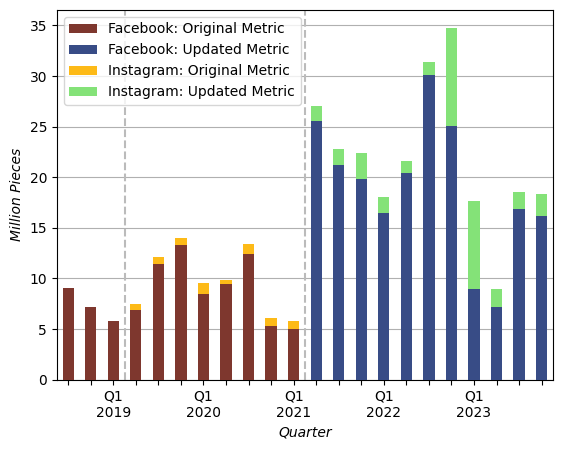

In [2]:
show('<h2>Quarterly Pieces</h2>')

brand_pieces = []
for brand in ('Facebook', 'Instagram'):
    brand_pieces.append(data.disclosures[brand][meta.CSAM_PIECES].rename(columns={
        meta.CSAM_PIECES[0]: f'{brand}: Original Metric',
        meta.CSAM_PIECES[1]: f'{brand}: Updated Metric',
    }))

brand_pieces = pd.concat(brand_pieces, axis=1).sort_index()

def plot_pieces(ax):
    brand_pieces.plot.bar(
        ax=ax,
        stacked=True,
        zorder=3,
        color = ('#7e372e', '#384c86','#fdba17','#84e278'),
        #color = ('#5a738a', '#776887','#fdba17','#84e278', '#776887', '#825aa9'),
        # color = ('#8080d0', '#7070c0', '#ff8060', '#ff7050'),
        # color = ('#4743a1', '#d1448f', '#ff6852', '#fac000'),
        # color = ('#4b4fbd', '#794cbd', '#363987', '#65409e'),
        # color = ('#a6c3d1', '#cbb3d0', '#364c80', '#563680'),
        # color = ("#b1d9fa", "#7ca7c9", "#47789a", "#004c6d"),
        # color=("#ede15b", "#edbf33", "#ef9b20", "#ea5545"),
    )
    ax.set_xlabel('Quarter', fontstyle='italic')
    ax.set_ylabel('Million Pieces', fontstyle='italic')
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))
    ax.grid(axis="y", zorder=0)

    LABEL_PATTERN = re.compile(r'(\d{4})(Q\d)')
    labels = []

    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % 4 == 2:
            label.set_text(LABEL_PATTERN.sub('\g<2>\n\g<1>', label.get_text()))
            label.set_rotation(0)
        else:
            label.set_visible(False)
        labels.append(label)

    ax.xaxis.set_ticklabels(labels)
    ax.axvline(2.5, color='#bbb', linestyle='dashed')  # after Q1 2019
    ax.axvline(10.5, color='#bbb', linestyle='dashed')  # after Q1 2021

fig, ax = plt.subplots()
plot_pieces(ax)
ax.get_figure().savefig(
    '../figure/meta-pieces-per-quarter.svg',
    format='svg',
    bbox_inches='tight'
)

In [3]:
quarterly_pieces = combine_brands(data)['Meta']['pieces']
assert quarterly_pieces.values == brand_pieces.sum(axis=1).values

yoy_change = (
    quarterly_pieces
    .to_frame()
    .assign(**{'Δ%': lambda df: df['pieces'].pct_change(periods=4) * 100})
)

show(yoy_change, caption='Pieces per Quarter<br>Year-Over-Year Change')

,pieces,Δ%
period,,
2018Q3,"9,000,000",⋯
2018Q4,"7,200,000",⋯
2019Q1,"5,800,000",⋯
2019Q2,"7,426,200",⋯
2019Q3,"12,155,800",35.06
2019Q4,"13,986,400",94.26
2020Q1,"9,500,000",63.79
2020Q2,"9,881,400",33.06
2020Q3,"13,400,000",10.24


In [4]:
yearly_pieces = (
    quarterly_pieces
    .groupby(quarterly_pieces.index.year)
    .sum()
    .loc[2019:2023]  # Drop Q3/4 2018
)

# Summing groups by index.year results in an integer index (go figure),
# so we have to explicitly restore the yearly index.
yearly_pieces = pd.Series(
    yearly_pieces.values,
    index=[pd.Period(y) for y in yearly_pieces.index],
)

pieces_and_reports = pd.DataFrame({
    "Pieces (Meta)": yearly_pieces,
    "Reports (NCMEC)": ncmec["Meta"],
}, index=[pd.Period(y) for y in range(2019, 2024)])

pieces_and_reports.index.name = "Year"
pieces_and_reports.insert(
    1,
    column="π",
    value=pieces_and_reports["Pieces (Meta)"] / pieces_and_reports["Reports (NCMEC)"],
)

show("<h2>Pieces vs Reports</h2>")
show(pieces_and_reports)

,Pieces (Meta),π,Reports (NCMEC)
Year,,,
2019,"39,368,400",2.48,"15,884,511"
2020,"38,890,800",1.92,"20,307,216"
2021,"78,012,400",2.90,"26,885,302"
2022,"105,800,000",3.89,"27,190,665"
2023,"63,300,000",2.06,"30,658,047"


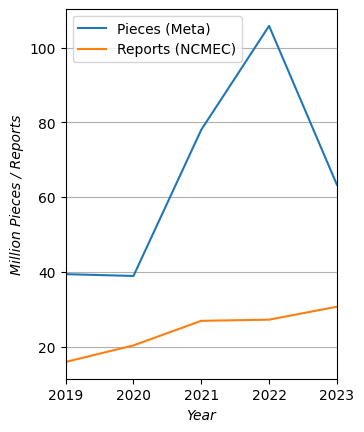

In [5]:
def plot_pieces_and_reports(ax):
    data = pieces_and_reports[["Pieces (Meta)", "Reports (NCMEC)"]]
    data.plot(ax=ax)

    ax.set_xlabel('Year', fontstyle='italic')
    ax.set_ylabel('Million Pieces / Reports', fontstyle='italic')
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))
    ax.grid(axis="y")

fig, ax = plt.subplots()
fig.set_figwidth(3.5)
plot_pieces_and_reports(ax)
fig.savefig("../figure/meta-pieces-v-reports.svg")

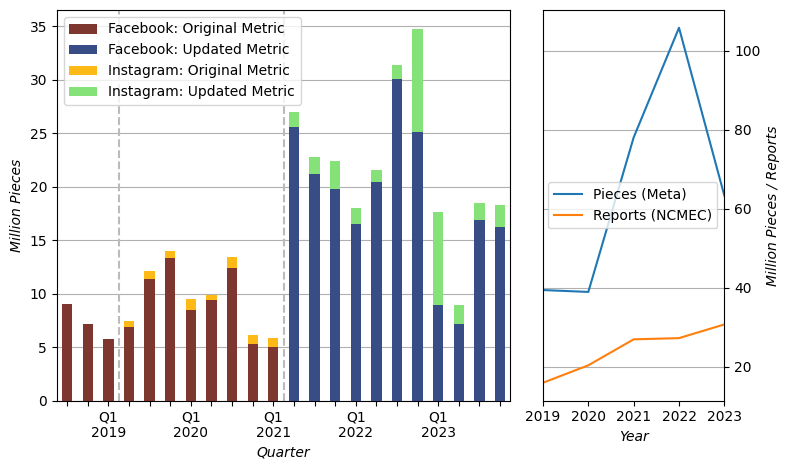

In [6]:
fig, ax = plt.subplots(
    nrows=1, ncols=2,
    figsize=[8, 4.8],
    width_ratios=[2.5, 1],
)

plot_pieces(ax[0])
plot_pieces_and_reports(ax[1])

ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()

plt.tight_layout()
fig.savefig('../figure/meta-illustrated.svg')

In [7]:
show(f'<h2>Meta Rewrites History</h2>')
show(
    """
    While testing an update to my data analysis code, I discovered that Meta had
    changed seemingly arbitrary entries for previously disclosed transparency
    statistics. This section tracks the extent of these unacknowledged and
    unexplained changes by comparing Meta's CSV files quarter over quarter.
    """
)

meta_disclosures = meta.read_all('../data/meta')
meta_differences = meta.diff_all(meta_disclosures)

show('<h3>Divergence for CSAM Metrics Only</h3>')

for p1, delta in meta_differences.items():
    p2 = p1 + 1

    show(f'<h2>Δ(Q{p2.quarter}-{p2.year} / Q{p1.quarter}-{p1.year})</h2>')
    csam_only = delta[delta['policy_area'].isin(meta.CSAM_POLICIES)]

    count = len(csam_only)
    show(f'There are {count} divergent CSAM metrics{"." if count == 0 else ":"}')
    if count > 0:
        show(csam_only)

,app,policy_area,metric,period,value_q2_2021,value_q3_2021
69,Facebook,Child Nudity & Sexual Exploitation,Content Actioned,2020Q1,"8,600,000.0","8,500,000.0"
651,Facebook,Child Nudity & Sexual Exploitation,Content Restored without appeal,2020Q1,"1,000.0",500.0
70,Facebook,Child Nudity & Sexual Exploitation,Content Actioned,2020Q2,"9,500,000.0","9,400,000.0"
652,Facebook,Child Nudity & Sexual Exploitation,Content Restored without appeal,2020Q2,70.0,50.0
653,Facebook,Child Nudity & Sexual Exploitation,Content Restored without appeal,2020Q3,"1,300.0","1,200.0"
72,Facebook,Child Nudity & Sexual Exploitation,Content Actioned,2020Q4,"5,400,000.0","5,300,000.0"
654,Facebook,Child Nudity & Sexual Exploitation,Content Restored without appeal,2020Q4,"3,300.0","3,200.0"
655,Facebook,Child Nudity & Sexual Exploitation,Content Restored without appeal,2021Q1,"46,700.0","46,600.0"
1058,Instagram,Child Nudity & Sexual Exploitation,Content Actioned,2021Q1,"812,300.0","812,400.0"
59,Facebook,Child Endangerment: Sexual Exploitation,Content Actioned,2021Q2,"25,700,000.0","25,600,000.0"


,app,policy_area,metric,period,value_q3_2021,value_q4_2021
474,Facebook,Child Endangerment: Sexual Exploitation,Content Restored with appeal,2021Q2,40.0,50.0
680,Facebook,Child Endangerment: Sexual Exploitation,Content Restored without appeal,2021Q2,"2,600.0","2,800.0"
63,Facebook,Child Endangerment: Sexual Exploitation,Content Actioned,2021Q3,"20,900,000.0","21,200,000.0"


,app,policy_area,metric,period,value_q4_2021,value_q1_2022
78,Facebook,Child Nudity & Sexual Exploitation,Content Actioned,2020Q2,"9,400,000.0","2,800,000.0"
330,Facebook,Child Nudity & Sexual Exploitation,Content Appealed,2020Q2,40.0,20.0
800,Facebook,Child Nudity & Sexual Exploitation,Content Restored without appeal,2020Q2,50.0,40.0
1035,Facebook,Child Nudity & Sexual Exploitation,Proactive rate,2020Q2,99.2,97.8
1287,Instagram,Child Nudity & Sexual Exploitation,Content Actioned,2020Q2,"481,400.0","158,200.0"
1926,Instagram,Child Nudity & Sexual Exploitation,Content Restored without appeal,2020Q2,30.0,20.0
2114,Instagram,Child Nudity & Sexual Exploitation,Proactive rate,2020Q2,95.8,91.3


,app,policy_area,metric,period,value_q1_2022,value_q2_2022
83,Facebook,Child Nudity & Sexual Exploitation,Content Actioned,2020Q3,"12,400,000.00","10,000,000.0"
1093,Facebook,Child Nudity & Sexual Exploitation,Proactive rate,2020Q3,99.40,99.5
1359,Instagram,Child Nudity & Sexual Exploitation,Content Actioned,2020Q3,"1,000,000.00","770,600.0"
1809,Instagram,Child Nudity & Sexual Exploitation,Content Restored with appeal,2020Q3,10.00,0.0
2234,Instagram,Child Nudity & Sexual Exploitation,Proactive rate,2020Q3,96.70,97.3
833,Facebook,Child Endangerment: Sexual Exploitation,Content Restored without appeal,2022Q1,"687,700.00","687,800.0"
2022,Instagram,Child Endangerment: Sexual Exploitation,Content Restored without appeal,2022Q1,"154,300.00","154,200.0"


,app,policy_area,metric,period,value_q2_2022,value_q3_2022
88,Facebook,Child Nudity & Sexual Exploitation,Content Actioned,2020Q4,"5,300,000.0","4,300,000.0"
368,Facebook,Child Nudity & Sexual Exploitation,Content Appealed,2020Q4,"4,600.0","4,100.0"
890,Facebook,Child Nudity & Sexual Exploitation,Content Restored without appeal,2020Q4,"3,200.0","2,700.0"
1151,Facebook,Child Nudity & Sexual Exploitation,Proactive rate,2020Q4,98.7,98.6
1431,Instagram,Child Nudity & Sexual Exploitation,Content Actioned,2020Q4,"809,400.0","658,900.0"
2142,Instagram,Child Nudity & Sexual Exploitation,Content Restored without appeal,2020Q4,"2,900.0","1,800.0"
2354,Instagram,Child Nudity & Sexual Exploitation,Proactive rate,2020Q4,97.9,97.7
355,Facebook,Child Endangerment: Sexual Exploitation,Content Appealed,2022Q2,"403,000.0","404,000.0"
616,Facebook,Child Endangerment: Sexual Exploitation,Content Restored with appeal,2022Q2,"1,300.0","1,400.0"
877,Facebook,Child Endangerment: Sexual Exploitation,Content Restored without appeal,2022Q2,"15,700.0","15,900.0"


,app,policy_area,metric,period,value_q3_2022,value_q4_2022
90,Facebook,Child Nudity & Sexual Exploitation,Content Actioned,2020Q2,"2,800,000.0","9,400,000.00"
384,Facebook,Child Nudity & Sexual Exploitation,Content Appealed,2020Q2,20.0,40.00
932,Facebook,Child Nudity & Sexual Exploitation,Content Restored without appeal,2020Q2,40.0,50.00
1500,Instagram,Child Nudity & Sexual Exploitation,Content Actioned,2020Q2,"158,200.0","481,400.00"
2247,Instagram,Child Nudity & Sexual Exploitation,Content Restored without appeal,2020Q2,20.0,30.00
91,Facebook,Child Nudity & Sexual Exploitation,Content Actioned,2020Q3,"10,000,000.0","12,400,000.00"
1501,Instagram,Child Nudity & Sexual Exploitation,Content Actioned,2020Q3,"770,600.0","1,000,000.00"
1999,Instagram,Child Nudity & Sexual Exploitation,Content Restored with appeal,2020Q3,0.0,10.00
92,Facebook,Child Nudity & Sexual Exploitation,Content Actioned,2020Q4,"4,300,000.0","5,300,000.00"
386,Facebook,Child Nudity & Sexual Exploitation,Content Appealed,2020Q4,"4,100.0","4,600.00"


,app,policy_area,metric,period,value_q4_2022,value_q1_2023
83,Facebook,Child Endangerment: Sexual Exploitation,Content Actioned,2022Q4,"25,100,000.0","25,200,000.0"
391,Facebook,Child Endangerment: Sexual Exploitation,Content Appealed,2022Q4,"23,000.0","23,300.0"
965,Facebook,Child Endangerment: Sexual Exploitation,Content Restored without appeal,2022Q4,"75,800.0","76,300.0"
1821,Instagram,Child Endangerment: Sexual Exploitation,Content Appealed,2022Q4,"5,800.0","5,900.0"


In [8]:
show("<h3>Quarterly Rate of Divergence (All Metrics)</h3>")
show(meta.rate_of_divergence(meta_disclosures, meta_differences))
show(
    """
    For each quarter, the abvove table shows the number of entries in that
    quarter's data that are different from the previous quarter's disclosure
    divided by the total number of entries from the previous quarter. In other
    words, newly added data points do not figure into this rate.
    """
)

,period,changed,total,rate_of_divergence
0,2021Q3,71,"1,904",3.729
1,2021Q4,27,"2,192",1.232
2,2022Q1,96,"2,339",4.104
3,2022Q2,102,"2,486",4.103
4,2022Q3,113,"2,633",4.292
5,2022Q4,203,"2,780",7.302
6,2023Q1,18,"2,927",0.615
7,2023Q2,0,"3,074",0.000
8,2023Q3,0,"3,221",0.000
9,2023Q4,0,"3,368",0.000


In [9]:
show("<h3>Divergence for All Metrics</h3>")

for p1, delta in meta_differences.items():
    p2 = p1 + 1

    show(f'<h2>Δ(Q{p2.quarter}-{p2.year} / Q{p1.quarter}-{p1.year})</h2>')
    show(meta.age_of_divergence(delta), margin_bottom=0)
    show(meta.descriptors_of_divergence(delta))

,divergent
period,
2020Q1,6
2020Q2,8
2020Q3,14
2020Q4,15
2021Q1,13
2021Q2,15


,divergent
period,
2021Q2,6
2021Q3,21


,divergent
period,
2020Q2,86
2021Q4,10


,divergent
period,
2020Q3,79
2020Q4,2
2021Q1,3
2021Q2,4
2021Q4,1
2022Q1,13


,divergent
period,
2020Q4,77
2021Q1,3
2021Q2,4
2022Q2,29


,divergent
period,
2020Q2,67
2020Q3,60
2020Q4,58
2022Q3,18


,divergent
period,
2022Q4,18


,divergent
period,


,divergent
period,


,divergent
period,
